In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_reader import read_consumption_and_weather

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

from models.lstm_model import LSTMModel

import copy

from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

df = df1[['consumption']]

# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

df_test = (df_test - train_mean) / train_std

df_test

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


,consumption
2022-06-26 19:00:00+00:00,-1.208172
2022-06-26 20:00:00+00:00,-1.234116
2022-06-26 21:00:00+00:00,-1.280757
2022-06-26 22:00:00+00:00,-1.406576
2022-06-26 23:00:00+00:00,-1.509782
...,...
2023-01-21 19:00:00+00:00,1.457580
2023-01-21 20:00:00+00:00,1.397170
2023-01-21 21:00:00+00:00,1.301162
2023-01-21 22:00:00+00:00,1.233762


In [8]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
    
tw = 100
pw = 1

test_dataset = SequenceDataset(generate_lstm_sequences(df_test, tw, pw))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [9]:
# Init model and load parameters
model = LSTMModel(device=device, n_features=1, n_hidden=64, n_outputs=1, sequence_len=100)
model.to(device)

model.load_state_dict(torch.load('trained_models/lstm.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
criterion = nn.MSELoss()

def make_preds(model, test_loader, criterion):
    model.eval()
    predictions, actuals, test_losses = [], [], []
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            p = model(x).squeeze()
            predictions.append(p)
            actuals.append(y.squeeze())
            loss = criterion(p, y.squeeze())
            test_losses.append(loss)
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()
    test_loss = sum(test_losses) / len(test_losses)
    return predictions.squeeze(), actuals, test_loss

predictions, actuals, test_loss = make_preds(model, test_loader, criterion)

In [11]:
print(predictions * train_std['consumption'] + train_mean['consumption'])
print(actuals * train_std['consumption'] + train_mean['consumption'])
print(f"Final test loss: {test_loss}")

[5254.8447 1888.8894 1909.9731 ... 5518.1426 2583.711  3623.8806]
[5231.9746 1922.9419 1907.1055 ... 5511.001  2613.296  3609.0996]
Final test loss: 0.000602914544288069


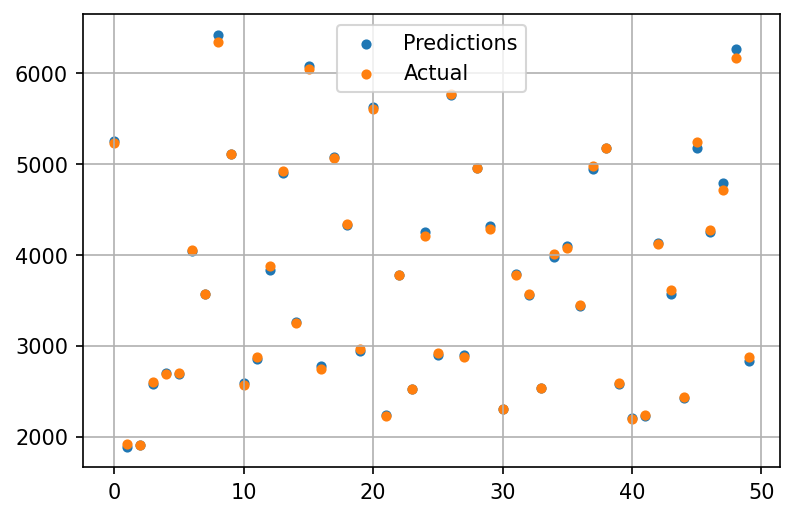

In [12]:
n = 50

pred = predictions[0:n] * train_std['consumption'] + train_mean['consumption']
act = actuals[0:n] * train_std['consumption'] + train_mean['consumption']

x = pred.shape[0]
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.scatter(range(x), pred, label="Predictions", s=15)
plt.scatter(range(x), act, label="Actual", s=15)
plt.legend()
plt.show()

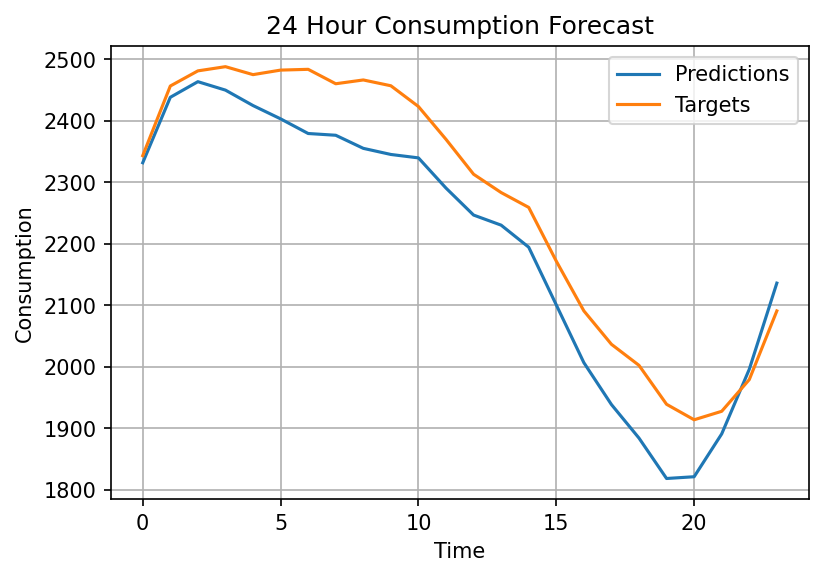

In [13]:
# Forecasting
start_point = 200
tw = 10
fw = 24

history = list(df_test.copy(deep=True)['consumption'])[start_point: start_point+tw+fw]
targets = copy.deepcopy(history)[tw:tw+fw]

predictions = []

# 24 timesteps into the future
for i in range(fw):
    x = np.array(history[i:tw+i]).reshape(-1, 1)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    pred = model(x)

    predictions.append(pred.item())

    history[-fw+i] = pred.item()

predictions = np.array(predictions) * train_std['consumption'] + train_mean['consumption']
targets = np.array(targets) * train_std['consumption'] + train_mean['consumption']

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.title("24 Hour Consumption Forecast")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.plot(x, predictions, label="Predictions")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()